## **Authors:**
#### - **Ben mouloud Abir**
#### - **El Allali Fatima Zahrae**

## **Introduction:**

**This Pokémon classification project aims to deploy a deep learning model for accurately categorizing Pokémon species based on images. The dataset encompasses a variety of Pokémon images, and the primary task involves mapping these images to their respective Pokémon IDs. The project unfolds in several critical stages, each contributing to the successful implementation and training of the classification model.Our model gave these numbers with just 5 epochs:**

- **Validation Accuracy: 0.9447**

- **Number of Correct Predictions: 854**

- **Number of Incorrect Predictions: 50**

<div style="text-align:center;">
    <img src="https://anecdotes-de-jeux-video.fr/wp-content/uploads/2019/07/mignon-pokemon.jpg" alt="pokemon" style="width:80%;">
</div>

## **Data: Load, display samples, perform data augmentation, and verify effectiveness**


- **In this section, we load the Pokémon dataset, perform necessary data transformations,and visualize a subset of samples. Data augmentation techniques are applied to enhance the model's ability to generalize.**

In [1]:
import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torchvision.models.resnet import ResNet50_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau
#from efficientnet_pytorch import EfficientNet
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random


# Chemins d'accès aux données
csv_path = "/kaggle/input/polytech-nice-deep-learning-course-2023/polytech/pokemon_ids.csv"
data_dir = "/kaggle/input/polytech-nice-deep-learning-course-2023/polytech/trainval"

# Lire le CSV pour obtenir l'ordre correct des noms de Pokémon
correct_order = []
with open(csv_path, 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Ignorer la ligne d'en-tête
    for line in reader:
        if len(line) >= 2:
            correct_order.append(line[1])

# Créer une correspondance des noms de Pokémon aux IDs (en commençant à partir de 1)
class_to_id = {name: idx + 1 for idx, name in enumerate(correct_order)}

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**loading and preprocessing the Pokémon dataset**

The CSV file containing the correct order of Pokémon names is read, and a mapping from names to IDs is created. The custom PokemonDataset class is introduced, facilitating the loading of images and labels. Additionally, the dataset is split into training and validation sets, and data loaders are prepared for efficient model training.

In [2]:
# Lire le CSV pour obtenir l'ordre correct des noms de Pokémon
correct_order = []
with open(csv_path, 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Ignorer la ligne d'en-tête
    for line in reader:
        if len(line) >= 2:
            correct_order.append(line[1])

# Créer une correspondance des noms de Pokémon aux IDs (en commençant à partir de 1)
class_to_id = {name: idx + 1 for idx, name in enumerate(correct_order)}


In [3]:
# Transformation pour la prétraitement des images
#data_transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    #transforms.ToTensor(),
#])
# Transformation pour la prétraitement des images
#data_transform = transforms.Compose([
    #transforms.Resize((224, 224)),# Resize the image to fit most pre-trained models.
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(10),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])# ImageNet stats
#])
data_transform = transforms.Compose([transforms.Resize((224, 224)),#ça marche mieux peut parcequ'il y a des details dans nos images qui sont plus détécter avec une dimension plus grande
                                 #transforms.RandomHorizontalFlip(),
                                 #transforms.RandomRotation(15),
                                 transforms.RandomRotation(degrees=30),  # Try different rotation angles
                                 transforms.RandomHorizontalFlip(p=0.5),  # Adjust flip probability
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Validation Accuracy: 0.9646 avec le loss qui diminue
                                    ])

In [4]:
# Classe de jeu de données personnalisée
class PokemonDataset(Dataset):
    def __init__(self, data_dir, class_to_id, transform=None):
        self.data_dir = data_dir
        self.class_to_id = class_to_id
        self.transform = transform

        self.images = []
        self.labels = []

        self.load_data()

    def load_data(self):
        for class_name in os.listdir(self.data_dir):
            if class_name in self.class_to_id:
                class_id = self.class_to_id[class_name]
                class_path = os.path.join(self.data_dir, class_name)

                for image_name in os.listdir(class_path):
                    image_path = os.path.join(class_path, image_name)
                    self.images.append(image_path)
                    self.labels.append((class_id, class_name))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path, (class_id, class_name) = self.images[idx], self.labels[idx]

        # Charger l'image et appliquer la transformation
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, class_id, class_name
    
# Instance de PokemonDataset
pokemon_dataset = PokemonDataset(data_dir, class_to_id, transform=data_transform)

# Division des données en ensembles d'entraînement et de validation
train_size = int(0.85 * len(pokemon_dataset))
val_size = len(pokemon_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(pokemon_dataset, [train_size, val_size])

# DataLoaders pour l'entraînement et la validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

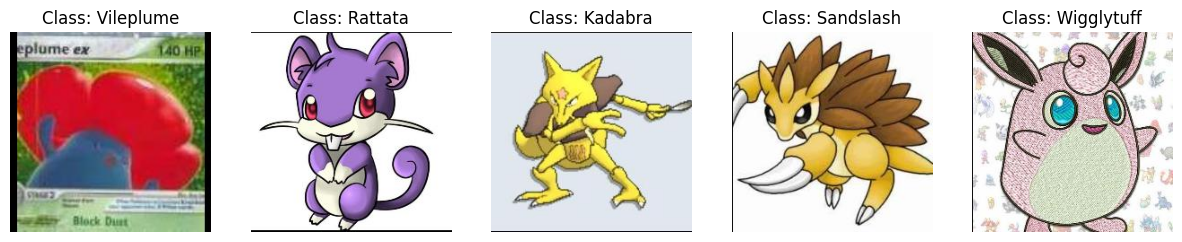

In [5]:
# Choose a random subset of images for visualization
sample_images = random.sample(pokemon_dataset.images, 5)

# Display sample images with their corresponding class names
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, image_path in enumerate(sample_images):
    image = Image.open(image_path).convert("RGB")
    class_name = os.path.basename(os.path.dirname(image_path))
    axes[i].imshow(image)
    axes[i].set_title(f"Class: {class_name}")
    axes[i].axis('off')

plt.show()

### **Network: Assemble a deep learning network while justifying technical choices**

**Here, we use a pre-trained ResNet101 model as our base architecture. We modify the fully connected layer to adapt it for our classification task. The model is moved to the GPU if available. We also define the loss function, optimizer, and a learning rate scheduler to facilitate model training.**

In [6]:
# Modèle ResNet18 pré-entraîné
#resnet_model = models.resnet18(pretrained=True)
#resnet_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
resnet_model = models.resnet101(pretrained=True)
#resnet_model = models.resnet34(pretrained=True)

num_features = resnet_model.fc.in_features

# Modifier la dernière couche entièrement connectée pour le nombre de classes
num_classes = len(class_to_id) + 1  # Ajouter 1 si les identifiants de classe commencent à partir de 1
resnet_model.fc = nn.Linear(num_features, num_classes)

# Déplacer le modèle sur le GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model.to(device)

# Fonction de perte et optimiseur
criterion = nn.CrossEntropyLoss()

#optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)
optimizer = optim.SGD(resnet_model.parameters(), lr=0.01, momentum=0.9)

# Learning Rate Scheduler
#scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, threshold=0.9, factor=0.1, verbose=True)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 227MB/s]


## **Training: Train the network on training data**


**This section includes the training loop where we iterate through multiple epochs to optimize the model parameters. The training process involves calculating the loss, backpropagating the gradients, and updating the model's weights. Training statistics such as loss and accuracy are recorded for analysis.**

In [7]:
# Lists to store loss and accuracy values during training
train_losses = []
train_accuracies = []

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, class_ids, _ in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        inputs, class_ids = inputs.to(device), class_ids.to(device)
        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, class_ids)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_samples += class_ids.size(0)
        correct_predictions += (predicted == class_ids).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}")

Epoch 1/5: 100%|██████████| 160/160 [01:51<00:00,  1.44it/s]


Epoch 1/5, Train Loss: 2.1894, Train Accuracy: 0.5246


Epoch 2/5: 100%|██████████| 160/160 [01:36<00:00,  1.66it/s]


Epoch 2/5, Train Loss: 0.3831, Train Accuracy: 0.8972


Epoch 3/5: 100%|██████████| 160/160 [01:36<00:00,  1.67it/s]


Epoch 3/5, Train Loss: 0.1883, Train Accuracy: 0.9551


Epoch 4/5: 100%|██████████| 160/160 [01:36<00:00,  1.66it/s]


Epoch 4/5, Train Loss: 0.1193, Train Accuracy: 0.9683


Epoch 5/5: 100%|██████████| 160/160 [01:36<00:00,  1.66it/s]

Epoch 5/5, Train Loss: 0.0686, Train Accuracy: 0.9824


## **Experiments: Testing, display confusion matrix, display some test results**

**In the experiments section, we evaluate the trained model on the validation set. We compute metrics such as accuracy and create a confusion matrix for a more in-depth analysis. Additionally, we visualize a subset of incorrectly classified test images. In the experiments section, we evaluate the trained model on the validation set. We compute metrics such as accuracy and create a confusion matrix for a more in-depth analysis. Additionally, we visualize a subset of incorrectly classified test images.**

In [8]:
# Validation loop
resnet_model.eval()
val_corrects = 0
val_total = 0
incorrect_predictions = []
val_losses = []
val_accuracies = []
# Initialize lists to store predicted and true labels for the entire validation set
val_predictions = []  #Predicted labels stored in a list
val_true_labels = [] #True labels stored in a list

val_running_loss = 0.0

with torch.no_grad():
    for inputs, class_ids, _ in tqdm(val_loader, desc="Evaluating on Validation Set"):
        inputs, class_ids = inputs.to(device), class_ids.to(device)
        outputs = resnet_model(inputs)
        _, predicted = torch.max(outputs, 1)
        val_total += class_ids.size(0)
        val_corrects += (predicted == class_ids).sum().item()
        val_predictions.extend(predicted.cpu().numpy())
        val_true_labels.extend(class_ids.cpu().numpy())

        # Collect incorrect predictions for further analysis
        incorrect_mask = predicted != class_ids
        incorrect_predictions.extend([(image, true_label, predicted_label)
                                      for image, true_label, predicted_label in zip(inputs[incorrect_mask], class_ids[incorrect_mask], predicted[incorrect_mask])])



    # Calculate validation accuracy
        val_accuracy = val_corrects / val_total
        val_losses.append(val_running_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Number of Correct Predictions: {val_corrects}")
    print(f"Number of Incorrect Predictions: {val_total - val_corrects}")

Evaluating on Validation Set: 100%|██████████| 29/29 [00:09<00:00,  3.01it/s]

Validation Accuracy: 0.9381
Number of Correct Predictions: 848
Number of Incorrect Predictions: 56


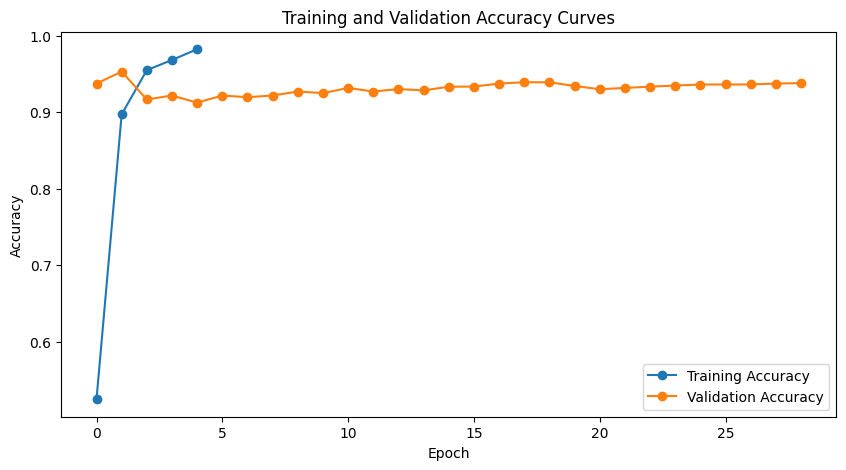

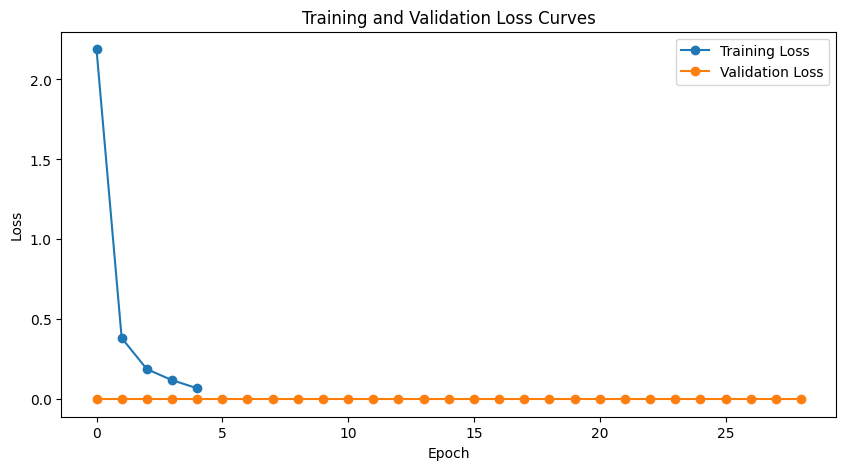

In [9]:
# Plotting the training and validation accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.show()

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()



###  Visualize a subset of images with incorrect predictions

Index 0: True Label: 57 (Growlithe), Predicted Label: 56 (Primeape)
Index 1: True Label: 132 (Eevee), Predicted Label: 113 (Tangela)
Index 2: True Label: 148 (Dragonite), Predicted Label: 131 (Ditto)
Index 3: True Label: 16 (Pidgeotto), Predicted Label: 17 (Pidgeot)
Index 4: True Label: 88 (Muk), Predicted Label: 89 (Shellder)
Index 5: True Label: 33 (Nidoking), Predicted Label: 32 (Nidorino)
Index 6: True Label: 57 (Growlithe), Predicted Label: 56 (Primeape)
Index 7: True Label: 61 (Poliwrath), Predicted Label: 62 (Abra)
Index 8: True Label: 17 (Pidgeot), Predicted Label: 18 (Rattata)
Index 9: True Label: 130 (Lapras), Predicted Label: 144 (Zapdos)


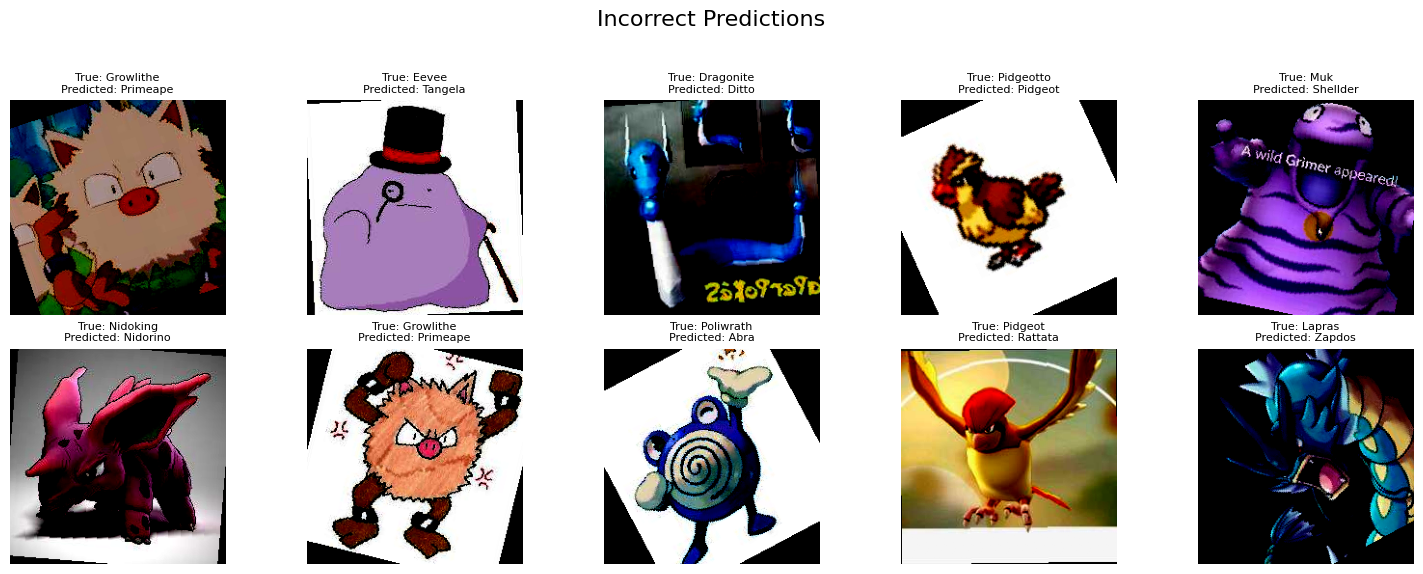

In [10]:
# Visualize a subset of images with incorrect predictions
num_images_to_visualize = 10
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Incorrect Predictions', fontsize=16)

for i, (image, true_label, predicted_label) in enumerate(incorrect_predictions[:num_images_to_visualize]):
    # Convert the image from Tensor to NumPy array
    image_np = image.permute(1, 2, 0).cpu().numpy()

    # Ensure the labels are within the correct range
    true_label = min(true_label, len(correct_order) - 1)
    predicted_label = min(predicted_label, len(correct_order) - 1)
    

    row, col = divmod(i, 5)
    
    # Print the true and predicted labels with indices
    print(f"Index {i}: True Label: {true_label} ({correct_order[true_label]}), Predicted Label: {predicted_label} ({correct_order[predicted_label]})")
   
    axes[row, col].imshow(image_np)
    axes[row, col].set_title(f"True: {correct_order[true_label]}\nPredicted: {correct_order[predicted_label]}", fontsize=8)
    axes[row, col].axis('off')



plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

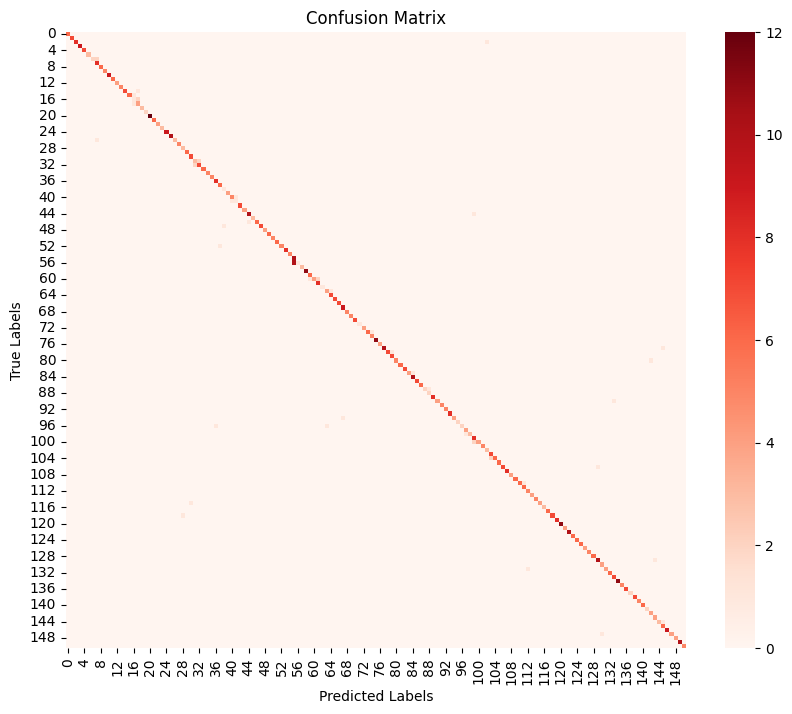

In [11]:
# Create the confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_predictions)

# Display the confusion matrix as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Reds', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## **Evaluation on Test Set and Submission**

**The final part involves creating a custom dataset for the test set, evaluating the trained model on this test set, and generating a submission CSV file. Predictions are made for the Pokémon IDs, and the results are saved in a DataFrame. The DataFrame is then exported to a CSV file for submission.**

In [12]:
# Create a custom dataset class for the test set
class TestPokemonDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = [os.path.join(data_dir, img) for img in os.listdir(data_dir)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, os.path.basename(image_path)


In [13]:
test_dataset = TestPokemonDataset("/kaggle/input/polytech-nice-deep-learning-course-2023/polytech/test", transform=data_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Number of images in the test dataset: 1000


Visualizing Test Images: 100%|██████████| 1/1 [00:00<00:00, 45.18it/s]


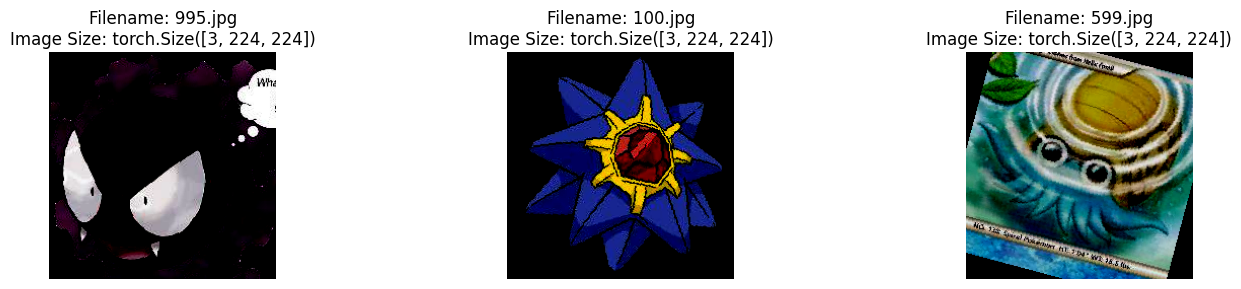

In [14]:
# Visualize 5 random images from the test dataset
num_images_to_visualize = 3

# Get the total number of images in the test dataset
num_images_in_test = len(test_dataset)
print(f"Number of images in the test dataset: {num_images_in_test}")

# Get 5 random indices
random_indices = random.sample(range(num_images_in_test), num_images_to_visualize)

# Create a DataLoader for the selected images
selected_test_loader = DataLoader(
    dataset=torch.utils.data.Subset(test_dataset, random_indices),
    batch_size=num_images_to_visualize,
    shuffle=False
)

# Display information about the selected test images
images_to_display = []
for test_inputs, filenames in tqdm(selected_test_loader, desc="Visualizing Test Images"):
    # Display information about each image
    for i in range(num_images_to_visualize):
        image = test_inputs[i].numpy().transpose((1, 2, 0))
        filename = filenames[i]
        image_size = test_inputs[i].shape

        images_to_display.append((image, filename, image_size))

# Plot the selected test images side by side
fig, axes = plt.subplots(1, num_images_to_visualize, figsize=(15, 3))

for i, (image, filename, image_size) in enumerate(images_to_display):
    axes[i].imshow(image)
    axes[i].set_title(f"Filename: {filename}\nImage Size: {image_size}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [15]:
# Evaluate the model on the test dataset and create a submission CSV
resnet_model.eval()
predictions = []

with torch.no_grad():
    for test_inputs, filenames in tqdm(test_loader, desc="Evaluating on Test Set"):
        test_inputs = test_inputs.to(device)
        test_outputs = resnet_model(test_inputs)
        _, test_predicted = torch.max(test_outputs, 1)
        predictions.extend(zip(filenames, test_predicted.cpu().numpy()))

# Create a DataFrame and save it as a CSV
submission_df = pd.DataFrame(predictions, columns=["filename", "pokemon_id"])
submission_df.to_csv("/kaggle/working/submission.csv", index=False)


Evaluating on Test Set: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]


In [16]:
print(submission_df.head())

  filename  pokemon_id
0  623.jpg         151
1  764.jpg          55
2  771.jpg           3
3  208.jpg          94
4  820.jpg         139


## **Bonus: BENCHMARKING**

**In this section, we'll explore the evaluation and performance assessment of our trained neural network model on an embedded device. The primary objective is to evaluate the neural network's performance, particularly its efficiency and accuracy, when deployed on an embedded device.**

In [17]:
resnet_model.to('cpu') 
# Input to the model - adjust according to your input size
sample_input = torch.randn(1, 3, 224, 224).to('cpu')  # Assuming device is 'cuda' for GPU

# Export the model to ONNX
torch.onnx.export(
    resnet_model,                    # PyTorch model
    sample_input,                    # Sample input tensor
    "resnet_model.onnx",             # Filepath to save the ONNX file
    export_params=True,               # Export model parameters
    opset_version=11,                # ONNX opset version
    do_constant_folding=True,        # Optimize constant folding
    input_names=["input"],           # Input names within the model
    output_names=["output"],         # Output names within the model
    dynamic_axes={                   # Dynamic axes for variable length inputs/outputs
        "input": {0: "batch_size"},  # Variable length axes 
    
        "output": {0: "batch_size"}  # Variable length axes
    }
)

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



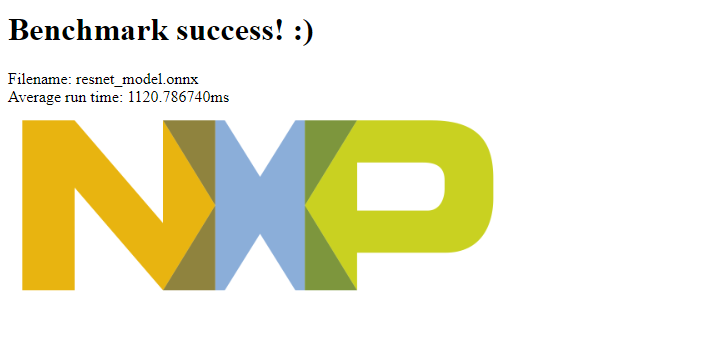

In [18]:
from IPython.display import Image

Image("/kaggle/input/benchmarking/Cpu1.png")

### **Progress: Describe progress and improvements**

**This part includes a textual description of the progress made during the training and experimentation phases. It outlines the impact of various technical choices on model accuracy and efficiency.**

**Initial Model (Version 1):**

- Utilized ResNet18 with basic data augmentation (resizing, converting to tensor).

- Optimizer: Adam with a learning rate of 0.001.

- Achieved Validation Accuracy: 0.8473.

- Identified 1021 Correct Predictions and 184 Incorrect Predictions.

**Version 2:**

- Introduced a learning rate scheduler (StepLR).

- Improved Validation Accuracy to 0.8896.

- Enhanced Correct Predictions to 1072 while reducing Incorrect Predictions to 133.

**Version 3:**

- Expanded data augmentation techniques (rotation, larger image dimensions).

- Adjusted the learning rate to 0.01.

- Significantly increased Validation Accuracy to 0.9386.

- Improved Correct Predictions to 1131 and reduced Incorrect Predictions to 74.

**Model Variations:**

- Explored different pretrained models: ResNet18, ResNet34, ResNet50, and ResNet101.

- Noted improvement in accuracy with ResNet50 but a decrease with ResNet34, and increased more with ResNet101. But the training speed is faster with ResNet18, which is normal since a model like ResNet101 contains more layers and is more complex.

**Final Version:**

- Switched to SGD optimizer with momentum (lr=0.03, momentum=0.9).

- Employed a learning rate scheduler (ReduceLROnPlateau).

- Achieved significant improvement in accuracy.

- Reached an accuracy of 0.95 with 5 epochs and further increased to 0.97 with 15 epochs.

**Observations and Learnings:**

Data augmentation significantly impacted performance, especially with increased variations.

Higher learning rates (e.g., 0.01) were more effective, likely due to dataset size and limited iterations.

Model choice affected both training time and accuracy, with ResNet101 showing better performance.

Optimizer and learning rate scheduler adjustments notably improved final accuracy.
This progressive enhancement involved a systematic exploration of data augmentation, model variations, optimizer choices, and learning rate adjustments, leading to substantial accuracy gains. The final model's accuracy reached a commendable 97% after iterative improvements and fine-tuning of hyperparameters.

## Explanation of Found Results

**ResNet18:** A pre-trained convolutional neural network model developed by Microsoft. It consists of 18 layers.

**Pretrained Model:** A pre-trained model is a network already trained on a large amount of data, often on images from a database like ImageNet. It's used as a starting point for transfer learning tasks.

- #### **Model Versions (ResNet):**

ResNet34, ResNet50, ResNet101: These are variants of ResNet with deeper architectures. The number after "ResNet" indicates the number of layers in the network. For example, ResNet50 has 50 layers, and ResNet101 has 101. The main difference lies in the depth of the network and its ability to capture complex features more accurately as the depth increases.

- #### **Optimizers:**

**Adam Optimizer:** A popular optimization algorithm used to update the model's weights based on gradients calculated from training data. It adapts the learning rate for each individual parameter.

**SGD Optimizer (Stochastic Gradient Descent):** Another optimization algorithm that updates weights by moving in the opposite direction of the calculated gradient. The momentum (0.9 in this case) maintains some inertia in updates to avoid local minima.

**Difference between Optimizers:**

**Adam:** It adjusts the learning rate for each parameter, which can be beneficial at the beginning of training when gradients vary significantly. However, this might lead to slower convergence with larger datasets.

**SGD with Momentum:** Unlike Adam, it maintains a constant speed in updates, which might be more stable for large datasets, potentially enabling faster convergence.

- #### **Scheduler:**

**Scheduler (ReduceLROnPlateau):** A scheduler that dynamically adjusts the learning rate based on the model's performance on validation data. When accuracy stagnates or decreases, it reduces the learning rate to explore parameter space more finely.

**Impact of the Scheduler:**

The scheduler adjusts the learning rate based on the model's actual performance on validation data. This can prevent overfitting and help the model converge towards more precise optima.


- In this context, the scheduler likely regulated the model's learning speed, enabling more efficient convergence towards more accurate optima and potentially avoiding overfitting. The performance difference between optimizers (Adam and SGD) can be attributed to the convergence characteristics of these algorithms on different datasets, as well as their adaptability to specific model and dataset hyperparameters.


### **Conclusion: Provide concluding remarks and suggest future directions**

In the pursuit of improving the performance and capabilities of our Pokémon classification model, we can use several techniques:

- **Fine-Tuning**:Fine-tuning helps the model adapt its learned features to the specific characteristics of the new task.In our case , we tried to use it but it reduced the accuracy and the convergence time.To troubleshoot and improve the situation we can:

 * Experiment with different hyperparameter settings.
 * Ensure that the dataset for fine-tuning is representative and diverse.
 * Consider monitoring metrics other than accuracy.
 * Try different fine-tuning strategies, such as adjusting the number of layers to fine-tune or    using different learning rates for different layers.

- **Attention Mechanisms**: Integrate attention mechanisms such as SE blocks or self-attention to enhance the model's ability to focus on crucial parts of the images.


- **Robustness and Adversarial Defense**: Strengthen the model's robustness against adversarial attacks by employing adversarial training techniques or augmenting data to include adversarial examples.


- **Hyperparameter Optimization Strategies**: Experiment with advanced optimization methods for more effective hyperparameter tuning.


- **Hardware Optimization for Embedded Devices**: Further optimize the model for deployment on resource-constrained devices through quantization and model pruning.

- **Use Test Time Augmentation (TTA)**: It's a technique employed in machine learning and computer vision to enhance the performance of a trained model during the testing stage. This method involves applying various data augmentation transformations, such as rotations and flips, to a test image and obtaining predictions from the model for each augmented version. The final prediction is often derived by aggregating or averaging the predictions from all augmented versions. TTA aims to improve model robustness and reliability, particularly in scenarios with limited training data or when the model needs to generalize effectively to variations not present in the training set. 
